In [3]:
import pandas as pd
import numpy as np
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib.patches as patches
import networkx as nx

In [22]:
%run ../modules/utils.ipynb
%run ../modules/cds.ipynb
%run ../modules/preprocessing.ipynb

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

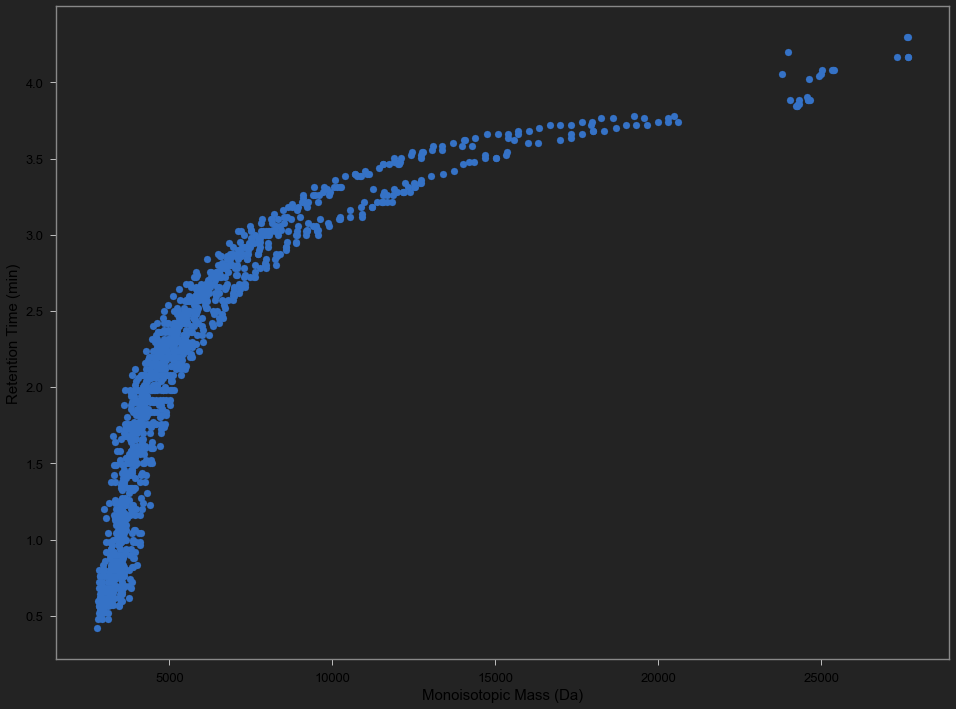

In [3]:
df = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/oligosdegradsample2-1.xlsx')
df.shape
df = thermo_df(df)
plot_zone(df)

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

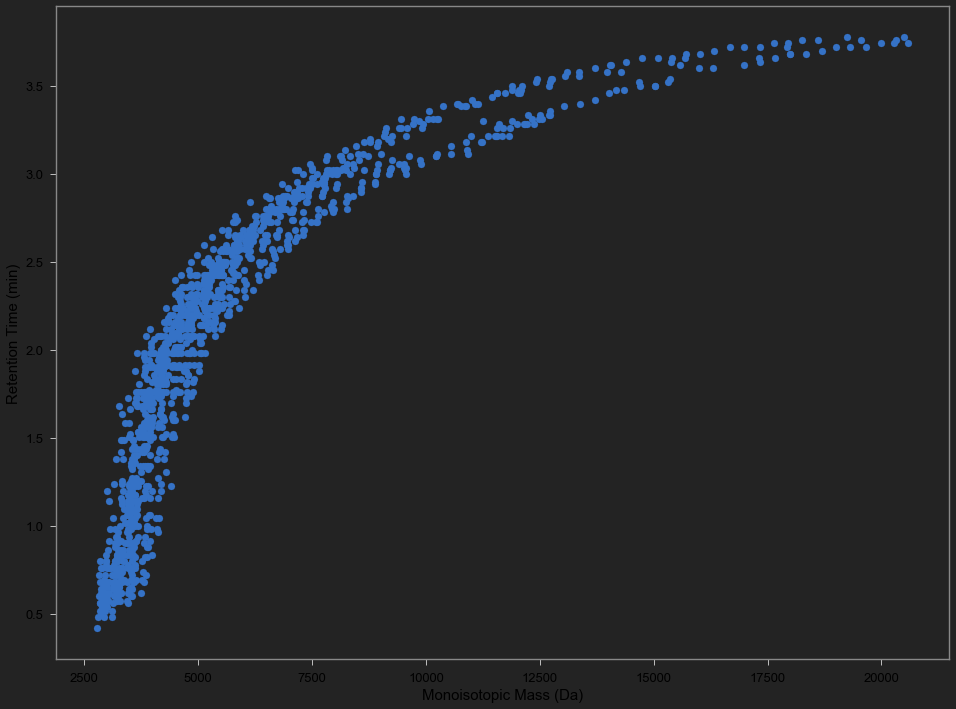

In [4]:
df_sample = df[(df.Mass < 22000)]
plot_zone(df_sample)

In [9]:
idxs = list()
# create our callback function
def on_selection(trace, points, selector):
    print('points {}'.format(points.point_inds) )
    idxs.extend(points.point_inds)

def on_click(trace, points, selector):
#     print('points {}'.format(points.point_inds) )
    idxs.extend(points.point_inds)

f = zone_selection(df_sample, on_selection=on_selection, on_click=on_click)
f

FigureWidget({
    'data': [{'marker': {'color': [#6371f2, #6371f2, #6371f2, ..., #6371f2,
                   …

In [10]:
df_chosen = df_sample.iloc[idxs]
df_chosen.shape

(30, 3)

In [11]:
# df_hi = df_chosen
df_lo = df_chosen

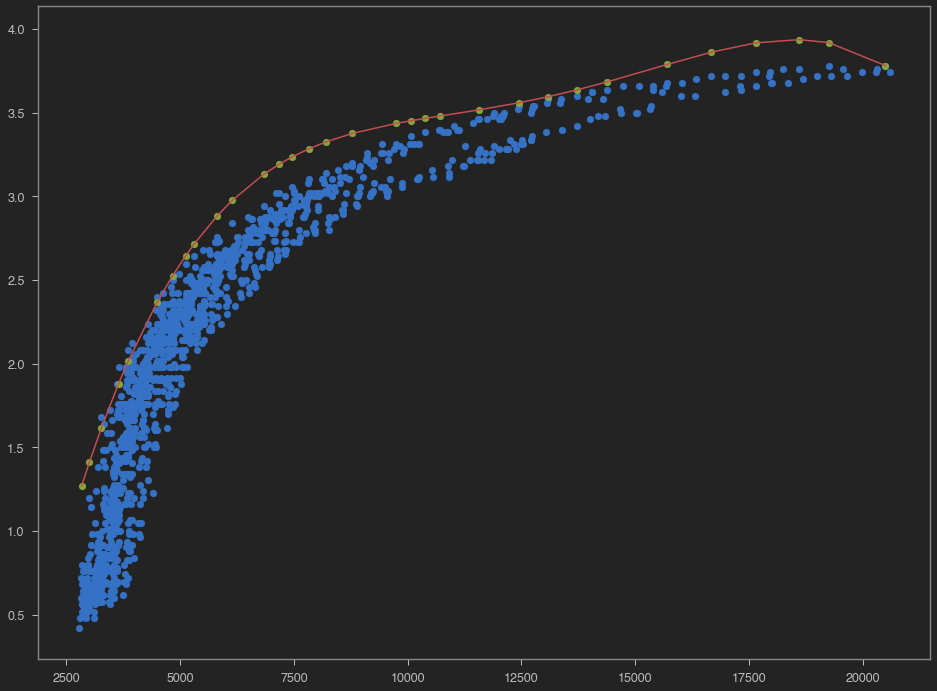

In [8]:
x = df_hi.Mass
y = df_hi.RT
z = np.polyfit(x, y, 4)
def f_hi2(x):
    return z[0] * x**4 + z[1]*x**3 + z[2]*x**2 + z[3]*x + z[4] + 0.1
y = f_hi2(x)
plt.figure(figsize=(16, 12))
plt.scatter(df_sample.Mass, df_sample.RT)
plt.plot(x, y, "r-")

plt.scatter(x, y)
plt.show()

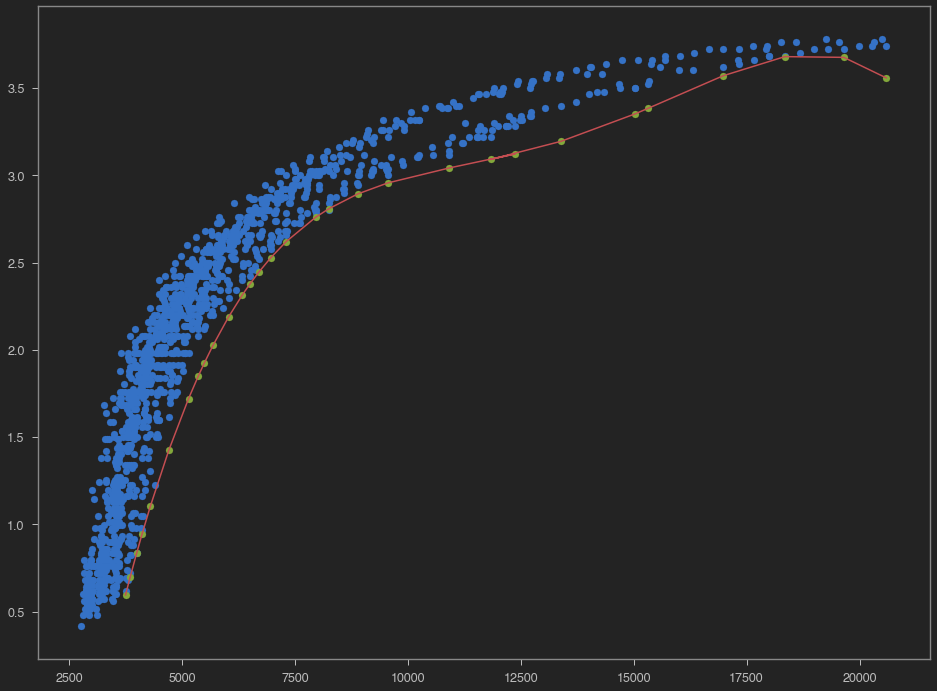

In [13]:
x = df_lo.Mass
y = df_lo.RT
z_lo = np.polyfit(x, y, 4)
def f_lo2(x):
    return z_lo[0] * x**4 + z_lo[1]*x**3 + z_lo[2]*x**2 + z_lo[3]*x + z_lo[4] - 0.1
#     return z_lo[0] * x**3 + z_lo[1]*x**2 + z_lo[2]*x + z_lo[3]
y = f_lo2(x)
plt.figure(figsize=(16, 12))
plt.plot(x, y, "r-")
plt.scatter(df_sample.Mass, df_sample.RT)
plt.scatter(x, y)
plt.show()

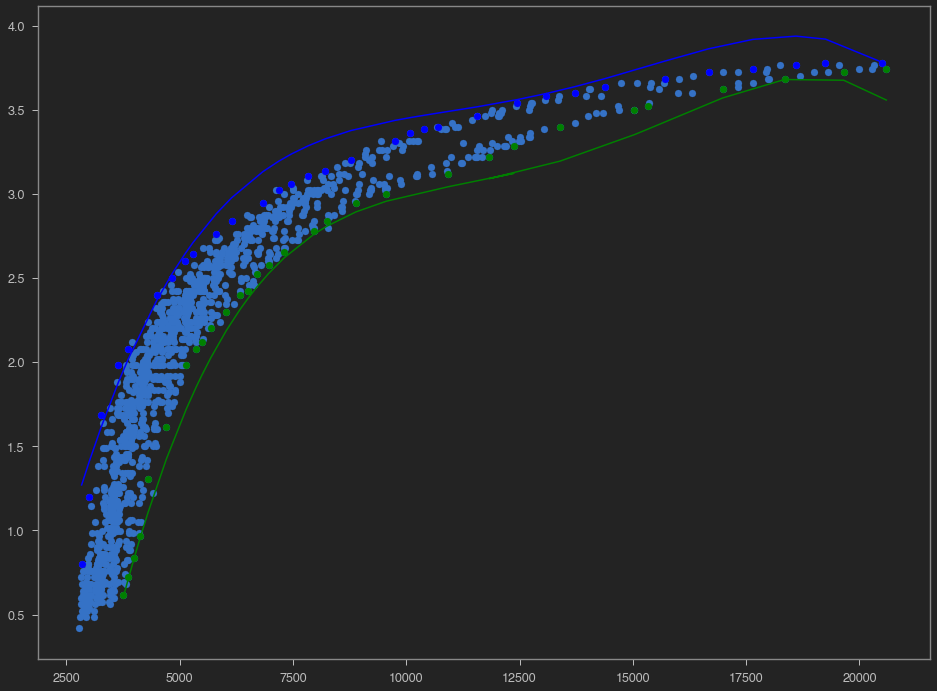

In [14]:
_, ax = plt.subplots(figsize=(16, 12))
ax.scatter(df_sample.Mass, df_sample.RT)

ax.scatter(df_hi.Mass, df_hi.RT, c='blue')
ax.plot(df_hi.Mass, f_hi2(df_hi.Mass), c='blue')

ax.scatter(df_lo.Mass, df_lo.RT, c='green')
ax.plot(df_lo.Mass, f_lo2(df_lo.Mass), c='green')

In [15]:
sample_rt_min = df_sample.RT.min()
sample_rt_max = df_sample.RT.max()

In [21]:
filter_min = 0.1
filter_nums = 10

def bin_range2(df, left, right, f_hi, f_lo, bin_num):
    rt = df.RT
    if rt.empty:
        return 0.0, 0.0
#     rt_min = rt.min()
#     rt_max = rt.max()
    rt_min = f_lo(left)
    rt_min = sample_rt_min if rt_min < sample_rt_min else rt_min
    rt_max = f_hi(right)
    rt_max = sample_rt_max if rt_max > sample_rt_max else rt_max
    rt_height = rt_max - rt_min
#     print(rt_min, rt_max, rt_height)
    
    bin_size = rt_height / filter_nums
    bin_size = filter_min if bin_size < filter_min else bin_size
    
    rt_hi = rt_max - bin_size * (bin_num - 1)
    rt_lo = rt_hi - bin_size
#     print(type(rt_lo), type(bin_size))
    if np.less(rt_lo, rt_min):
        print('Reach the last bin.')
        rt_lo = rt_min
        rt_hi = rt_lo + bin_size
    print('df_win count {} winRT {}-{} filterRT lo-hi {}-{}'.format(df.shape[0], rt_min, rt_max, rt_lo, rt_hi))
    return rt_lo, rt_hi

In [22]:
def create_rectangle(left, right, lo, hi):
    rect = patches.Rectangle((left, lo), right-left, hi-lo)
    return rect

df_win count 1 winRT 0.418642699289322-1.2220259293553841 filterRT lo-hi 1.122025929355384-1.2220259293553841
df_win count 1 winRT 0.418642699289322-1.2478454393609413 filterRT lo-hi 1.1478454393609412-1.2478454393609413
df_win count 1 winRT 0.418642699289322-1.2564006567515453 filterRT lo-hi 1.1564006567515452-1.2564006567515453
df_win count 1 winRT 0.418642699289322-1.2649303177966784 filterRT lo-hi 1.1649303177966783-1.2649303177966784
df_win count 3 winRT 0.418642699289322-1.2734344743970367 filterRT lo-hi 1.1734344743970366-1.2734344743970367
df_win count 2 winRT 0.418642699289322-1.2819131784030522 filterRT lo-hi 1.181913178403052-1.2819131784030522
df_win count 2 winRT 0.418642699289322-1.290366481614893 filterRT lo-hi 1.190366481614893-1.290366481614893
df_win count 2 winRT 0.418642699289322-1.2987944357824648 filterRT lo-hi 1.1987944357824647-1.2987944357824648
df_win count 4 winRT 0.418642699289322-1.3071970926054104 filterRT lo-hi 1.2071970926054103-1.3071970926054104
df_win

df_win count 4 winRT 0.4842142401668733-1.882242601959439 filterRT lo-hi 1.7424397657801824-1.882242601959439
df_win count 5 winRT 0.4946475289625166-1.888827222832281 filterRT lo-hi 1.7494092534453047-1.888827222832281
df_win count 3 winRT 0.5050478206432555-1.8953904717989247 filterRT lo-hi 1.7563562066833578-1.8953904717989247
df_win count 5 winRT 0.5154151858339603-1.901932396537918 filterRT lo-hi 1.7632806754675223-1.901932396537918
df_win count 2 winRT 0.5257496950881283-1.908453044677541 filterRT lo-hi 1.7701827097185996-1.908453044677541
df_win count 2 winRT 0.5360514188879023-1.914952463795815 filterRT lo-hi 1.7770623593050239-1.914952463795815
df_win count 1 winRT 0.5463204276440529-1.9214307014204963 filterRT lo-hi 1.783919674042852-1.9214307014204963
df_win count 3 winRT 0.5769318666880455-1.9407387998565757 filterRT lo-hi 1.8043581065397227-1.9407387998565757
df_win count 2 winRT 0.5870707179501565-1.9471327857791638 filterRT lo-hi 1.8111265789962632-1.9471327857791638
df_

df_win count 4 winRT 1.2600752081795545-2.3702451079283953 filterRT lo-hi 2.259228117953511-2.3702451079283953
df_win count 7 winRT 1.267948824324019-2.3751783646420965 filterRT lo-hi 2.2644554106102888-2.3751783646420965
df_win count 2 winRT 1.2757951916964525-2.3800941226847185 filterRT lo-hi 2.2696642295858918-2.3800941226847185
df_win count 2 winRT 1.2836143748557522-2.384992425462397 filterRT lo-hi 2.2748546204017326-2.384992425462397
df_win count 6 winRT 1.291406438289449-2.3898733163310015 filterRT lo-hi 2.2800266285268465-2.3898733163310015
df_win count 6 winRT 1.2991714464137085-2.394736838596137 filterRT lo-hi 2.285180299377894-2.394736838596137
df_win count 4 winRT 1.3069094635733323-2.3995830355131447 filterRT lo-hi 2.2903156783191636-2.3995830355131447
df_win count 3 winRT 1.314620554041761-2.404411950287107 filterRT lo-hi 2.295432810662572-2.404411950287107
df_win count 4 winRT 1.3223047820210652-2.4092236260728366 filterRT lo-hi 2.3005317416676596-2.4092236260728366
df_w

df_win count 2 winRT 1.8266583722100544-2.7240532708993315 filterRT lo-hi 2.6240532708993314-2.7240532708993315
df_win count 1 winRT 1.8324834771667207-2.7276772307087467 filterRT lo-hi 2.6276772307087466-2.7276772307087467
df_win count 2 winRT 1.838286448886707-2.731287123508857 filterRT lo-hi 2.631287123508857-2.731287123508857
df_win count 1 winRT 1.8440673460056582-2.7348829885339137 filterRT lo-hi 2.6348829885339136-2.7348829885339137
df_win count 4 winRT 1.8498262270878736-2.738464864967898 filterRT lo-hi 2.638464864967898-2.738464864967898
df_win count 1 winRT 1.8555631506262684-2.7420327919445344 filterRT lo-hi 2.6420327919445343-2.7420327919445344
df_win count 1 winRT 1.866971358686477-2.7491269538093195 filterRT lo-hi 2.6491269538093194-2.7491269538093195
df_win count 2 winRT 1.8726427598373188-2.7526532667135934 filterRT lo-hi 2.6526532667135934-2.7526532667135934
df_win count 2 winRT 1.8782924367023912-2.7561657861927604 filterRT lo-hi 2.6561657861927603-2.7561657861927604


df_win count 1 winRT 2.2689803723123467-2.998352087671598 filterRT lo-hi 2.898352087671598-2.998352087671598
df_win count 1 winRT 2.27708236158349-3.003359664753527 filterRT lo-hi 2.903359664753527-3.003359664753527
df_win count 1 winRT 2.281107695668506-3.005847382155444 filterRT lo-hi 2.905847382155444-3.005847382155444
df_win count 1 winRT 2.285115992265602-3.0083244316950837 filterRT lo-hi 2.9083244316950836-3.0083244316950837
df_win count 1 winRT 2.289107303444902-3.0107908479824403 filterRT lo-hi 2.9107908479824403-3.0107908479824403
df_win count 1 winRT 2.3049037328890374-3.0205508710495574 filterRT lo-hi 2.9205508710495574-3.0205508710495574
df_win count 1 winRT 2.3127013836824566-3.0253679792347365 filterRT lo-hi 2.9253679792347365-3.0253679792347365
df_win count 1 winRT 2.3165752489062483-3.027760927613637 filterRT lo-hi 2.9277609276136367-3.027760927613637
df_win count 2 winRT 2.3204325427041765-3.03014351781067 filterRT lo-hi 2.93014351781067-3.03014351781067
df_win count 1

df_win count 2 winRT 2.822121456458374-3.340376176965313 filterRT lo-hi 3.240376176965313-3.340376176965313
df_win count 1 winRT 2.82800182484865-3.344071277662359 filterRT lo-hi 3.244071277662359-3.344071277662359
df_win count 1 winRT 2.830896514140617-3.345892147290274 filterRT lo-hi 3.2458921472902738-3.345892147290274
df_win count 1 winRT 2.832332614166567-3.3467959956314446 filterRT lo-hi 3.2467959956314445-3.3467959956314446
df_win count 1 winRT 2.840794098933635-3.3521283715005805 filterRT lo-hi 3.2521283715005804-3.3521283715005805
df_win count 1 winRT 2.8449267641415985-3.354737305278839 filterRT lo-hi 3.254737305278839-3.354737305278839
df_win count 1 winRT 2.8476462135664575-3.3564558191645397 filterRT lo-hi 3.2564558191645396-3.3564558191645397
df_win count 1 winRT 2.8530008212495406-3.3598438236830614 filterRT lo-hi 3.2598438236830614-3.3598438236830614
df_win count 1 winRT 2.8543221212343357-3.36068074660261 filterRT lo-hi 3.2606807466026098-3.36068074660261
df_win count 

df_win count 1 winRT 3.0695204846789443-3.512483662800053 filterRT lo-hi 3.412483662800053-3.512483662800053
df_win count 1 winRT 3.0737681279838767-3.5160160444626585 filterRT lo-hi 3.4160160444626584-3.5160160444626585
df_win count 1 winRT 3.074301235020369-3.516460228103498 filterRT lo-hi 3.4164602281034977-3.516460228103498
df_win count 1 winRT 3.074834868815367-3.5169050248705305 filterRT lo-hi 3.4169050248705304-3.5169050248705305
df_win count 2 winRT 3.0753690437586143-3.517350442834513 filterRT lo-hi 3.417350442834513-3.517350442834513
df_win count 1 winRT 3.0759037741685034-3.5177964900159506 filterRT lo-hi 3.4177964900159505-3.5177964900159506
df_win count 1 winRT 3.077511440311207-3.519138486316049 filterRT lo-hi 3.419138486316049-3.519138486316049
df_win count 1 winRT 3.0812847279493183-3.5222932973619394 filterRT lo-hi 3.4222932973619393-3.5222932973619394
df_win count 1 winRT 3.0829122019386275-3.5236559200108784 filterRT lo-hi 3.4236559200108783-3.5236559200108784
df_win

Reach the last bin.
df_win count 1 winRT 3.6959879692623274-3.77890914436976 filterRT lo-hi 3.6959879692623274-3.7959879692623275
Reach the last bin.
df_win count 1 winRT 3.693267092692176-3.77890914436976 filterRT lo-hi 3.693267092692176-3.793267092692176
Reach the last bin.
df_win count 1 winRT 3.691748427571285-3.77890914436976 filterRT lo-hi 3.691748427571285-3.791748427571285
Reach the last bin.
df_win count 1 winRT 3.6815185647967197-3.77890914436976 filterRT lo-hi 3.6815185647967197-3.7815185647967198
df_win count 1 winRT 3.6755639632769515-3.77890914436976 filterRT lo-hi 3.67890914436976-3.77890914436976
df_win count 1 winRT 3.6476655520615195-3.77890914436976 filterRT lo-hi 3.67890914436976-3.77890914436976
df_win count 1 winRT 3.610281269871281-3.77890914436976 filterRT lo-hi 3.67890914436976-3.77890914436976
df_win count 1 winRT 3.6073497200543385-3.77890914436976 filterRT lo-hi 3.67890914436976-3.77890914436976
df_win count 1 winRT 3.5765990273377795-3.77890914436976 filter

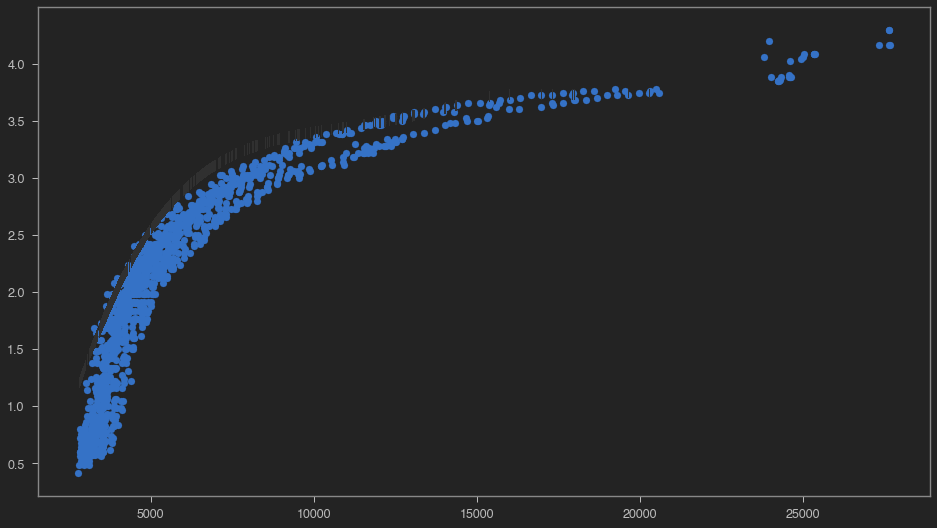

In [23]:
cursor = 0
mass_win_size = 10
bin_num = 1
last_rt_lo = 0.0

# plt.figure(figsize=(16, 9))
fig, ax = plt.subplots(1, figsize=(16, 9))
ax.scatter(df.Mass, df.RT)
filters = list()
while cursor < df_sample.Mass.max():
    # do sth
#     print('processing win {}-{}'.format(cursor, cursor+mass_win_size))
    df_win = df[(df.Mass >= cursor) & (df.Mass < cursor + mass_win_size)]
    rt_lo, rt_hi = bin_range2(df_win, cursor, cursor+mass_win_size, f_hi2, f_lo2, bin_num)
    if rt_lo < last_rt_lo:
        rt_lo = last_rt_lo
        if rt_lo >= rt_hi:
            cursor += mass_win_size
            continue
            
    if np.isclose(rt_lo, 0.0) or np.isclose(rt_hi, 0.0):
        cursor += mass_win_size
        continue
    
    rect = create_rectangle(cursor, cursor+mass_win_size, rt_lo, rt_hi)
    ax.add_patch(rect)
    
    last_rt_lo = rt_lo
    df_filter = df_win[(df_win.RT>=rt_lo) & (df_win.RT<=rt_hi)]
#     print(cursor, df_filter.shape)
    filters.append(df_filter)
    cursor += mass_win_size

plt.show()

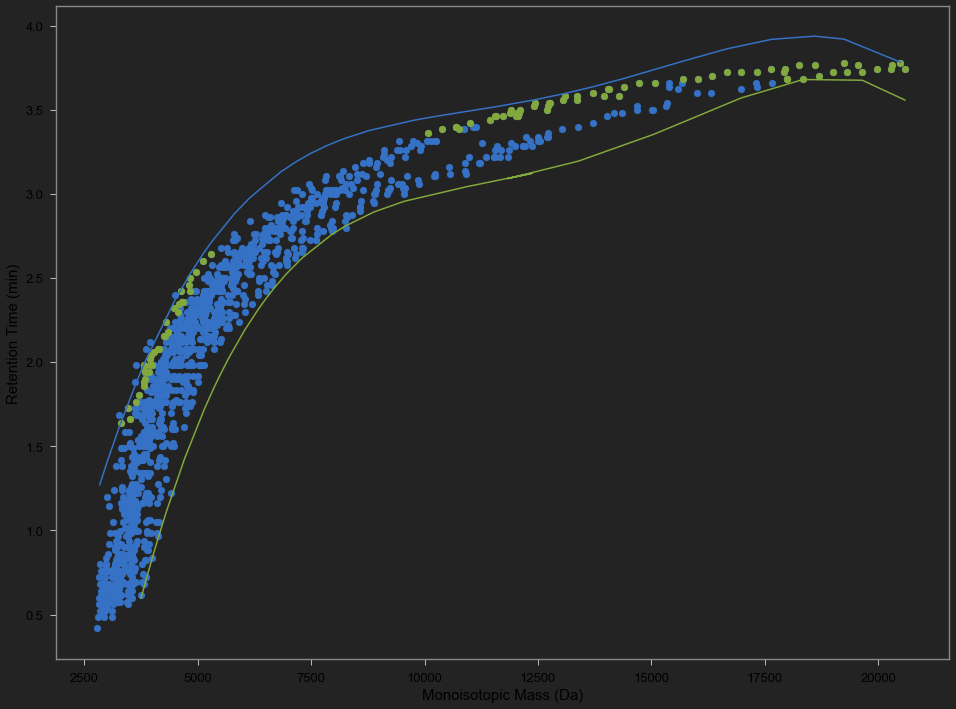

In [24]:
df_filters = pd.concat(filters)
plt = plot_zones(df_sample, df_filters)
plt.plot(df_hi.Mass, f_hi2(df_hi.Mass))
plt.plot(df_lo.Mass, f_lo2(df_lo.Mass))
# plt.savefig('/Users/bryan/Documents/Presentations/Jan 12 2021/filter_{}_bin_{}_filters_{}.png'.format(filter_min, bin_num, filter_nums), transparent=True)

mass_x (884,) mass_y (884,)
df3_idxs 239 df5_idxs 239
df3_idxs 271 df5_idxs 271
df3_idxs 269 df5_idxs 269
df3_idxs 226 df5_idxs 226
df3_idxs 102 df5_idxs 102
df3_idxs 94 df5_idxs 94
df3_idxs 83 df5_idxs 83
df3_idxs 122 df5_idxs 122


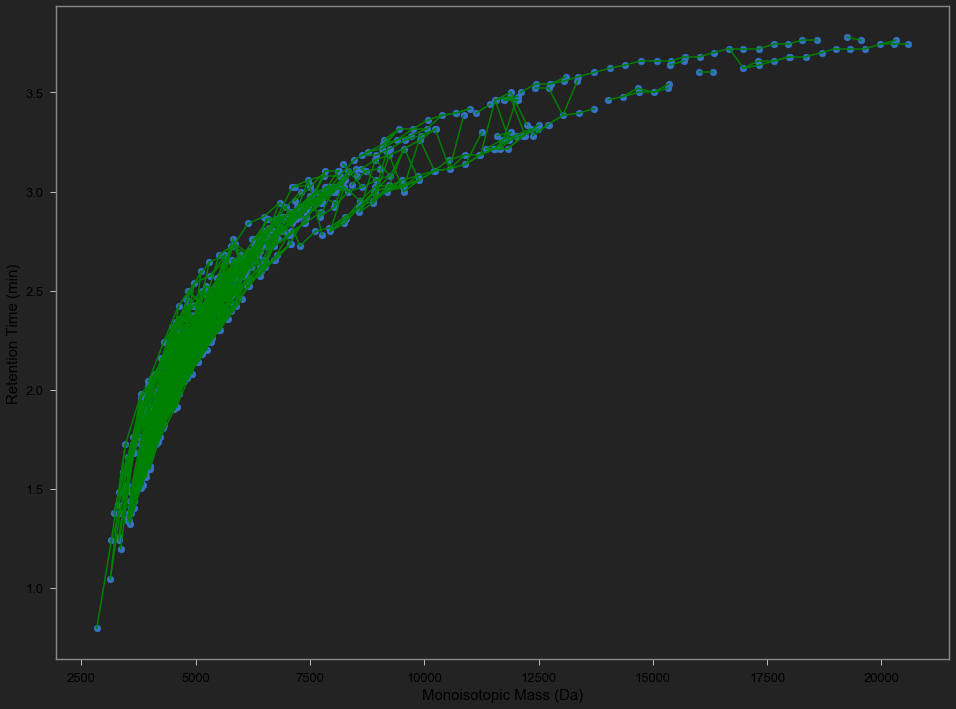

In [20]:
bcr_5p = base_calling_random(df_filters)
plt, _ = plot_basecalling(*bcr_5p, annotate=False)
# plt.savefig('/Users/bryan/Documents/Presentations/Jan 12 2021/filter_bc_{}_bin_{}_filters_{}.png'.format(filter_min, bin_num, filter_nums), transparent=True)

In [95]:
G = nx.DiGraph()

df_bcr = bcr_5p[0]
mass_pairs = bcr_5p[1]
for t in mass_pairs:
    G.add_edge(t[1], t[0], base=t[-1])

path = longest_path(G)
seqs = [G.edges[path[i], path[i+1]]['base'] for i in range(len(path)-1)]
print('longest sequence: ' + ''.join(seqs))
print(path)

longest sequence: ACUGACCCGAAU
[2484.3565, 2813.408, 3118.4442, 3424.4687, 3769.5112, 4098.5636, 4403.6036, 4708.6422, 5013.677, 5358.7393, 5687.7721, 6016.7871, 6322.8399]


In [40]:
def longest_path(G):
    dist = {} # stores [node, distance] pair
    for node in nx.topological_sort(G):
        # pairs of dist,node for all incoming edges
        pairs = [(dist[v][0]+1,v) for v in G.pred[node]] 
        if pairs:
            dist[node] = max(pairs)
        else:
            dist[node] = (0, node)
    node,(length,_)  = max(dist.items(), key=lambda x:x[1])
    path = []
    while length > 0:
        path.append(node)
        length,node = dist[node]
    return list(reversed(path))

# Mass Sum -- Phe

(1365, 13)


<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

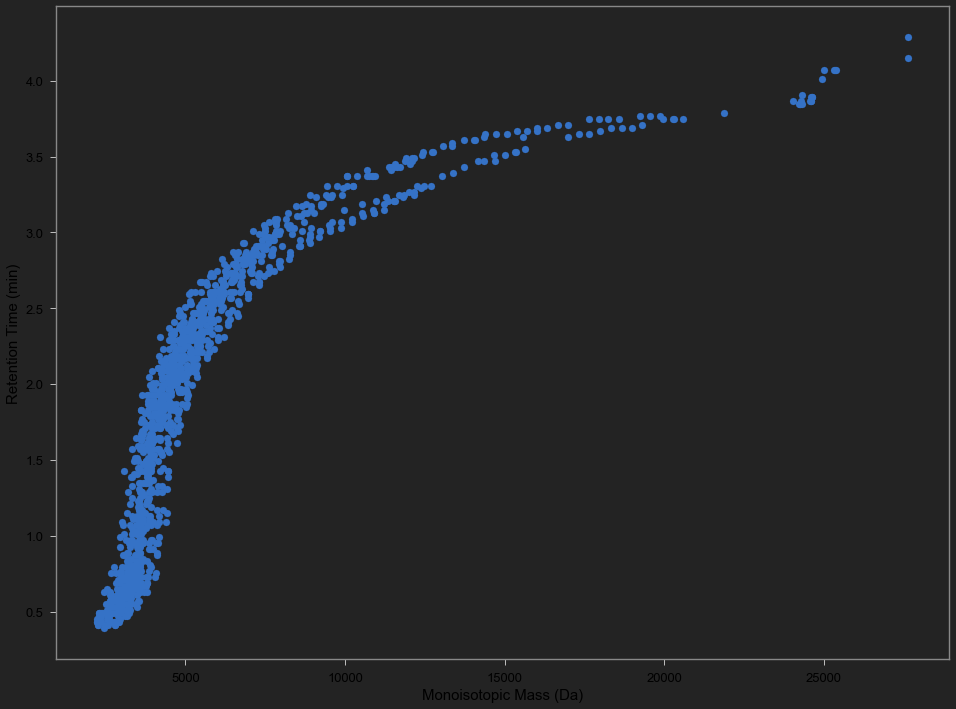

In [12]:
# df_phe = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/total_tRNA_acid_degradated_20to40_component_only.xlsx')
df_phe = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/Sigma_tRNA_standard_150pmol_Degradation.xlsx')
# df_phe = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/Sigma_tRNA_standard_150pmol_Degradation_all_level.xlsx')
# df_phe = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/tRNA_Phe_0724.xlsx')
# df_phe = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/tRNA_Phe_0724_COMBINE2.xlsx')
print(df_phe.shape)
df_phe = thermo_df(df_phe)
plot_zone(df_phe)

In [18]:
df_phe_25k = df_phe[(df_phe.Mass > 23000) & (df_phe.Mass < 26000)]
px.scatter(x=df_phe_25k.Mass, y=df_phe_25k.Vol)

In [15]:
df_phe[df_phe.Mass > 24000].sort_values('Mass')

,Mass,RT,Vol
244,24027.234006,3.870206,992397.14
270,24237.302897,3.849740,915340.72
0,24252.315242,3.849740,29465418.58
48,24268.314529,3.849740,3162639.36
23,24280.349256,3.870206,4924875.25
141,24308.323496,3.849740,1533113.94
274,24332.315712,3.909092,907955.21
6,24581.374101,3.870206,16763566.61
88,24596.358519,3.870206,2036460.61
120,24609.383976,3.890799,1754610.95


In [16]:
df_sample = df_phe[df_phe.Mass < 25000]

In [23]:
full_mass = 24252.315242 #24581.374101 
df_3p_cc, df_5p_cc = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 20 df5 20


In [24]:
full_mass =24252.315242 - 14 #24581.374101 
df_3p_cc_m1m, df_5p_cc_m1m = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 6 df5 6


In [25]:
full_mass = 24252.315242 - 14*2 #24238.334749 #24252.315242 #24581.374101 
df_3p_cc_m2m, df_5p_cc_m2m = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 0 df5 0


In [29]:
full_mass = 24252.315242 + 14*2 #24238.334749 #24252.315242 #24581.374101 
df_3p_cc_a2m, df_5p_cc_a2m = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 6 df5 6


In [26]:
full_mass = 24581.374101 
df_3p_cca, df_5p_cca = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 68 df5 68


In [27]:
full_mass = 24581.374101 - 14 #24238.334749 #24252.315242 #24581.374101 
df_3p_cca_m1m, df_5p_cca_m1m = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 12 df5 12


In [28]:
full_mass = 24581.374101 + 14*2 #24238.334749 #24252.315242 #24581.374101 
df_3p_cca_a2m, df_5p_cca_a2m = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 10 df5 10


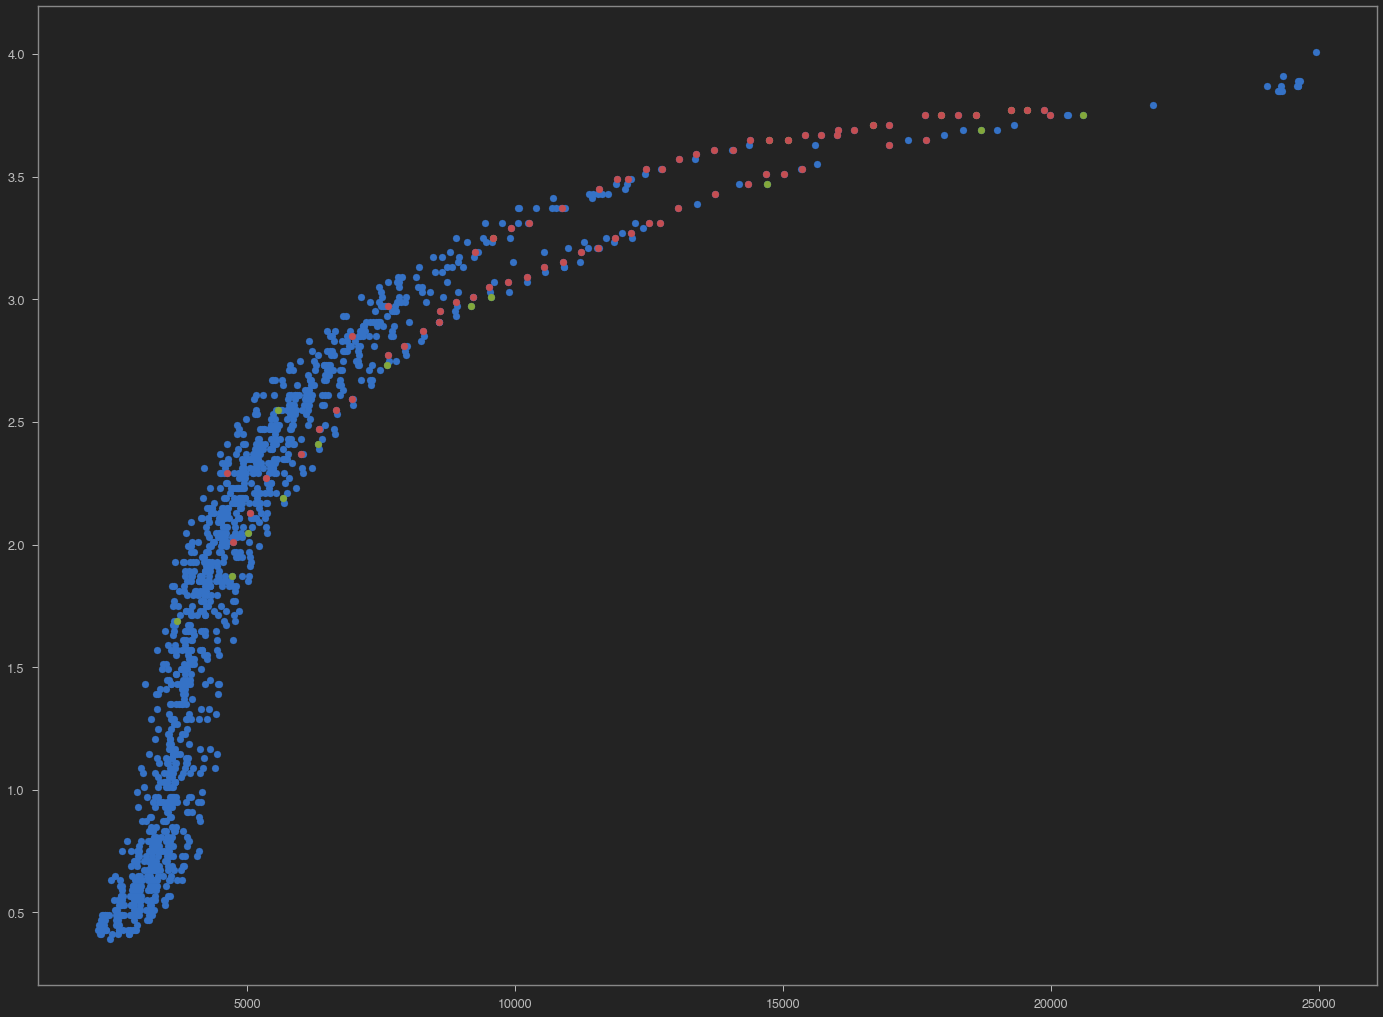

In [50]:
plt.figure(figsize=(24, 18))
plt.scatter(df_sample.Mass, df_sample.RT)
plt.scatter(df_3p_cc.Mass, df_3p_cc.RT)
# plot_zone(df_3p_cc, trend=True)
plt.scatter(df_3p_cca.Mass, df_3p_cca.RT)
# px.scatter(df_3p_cc, x='Mass', y='RT')
# px.scatter(df_3p_cca, x='Mass', y='RT')
# plt.scatter(df_3p_cc_m1m.Mass, df_3p_cc_m1m.RT)
# plt.scatter(df_3p_cc_m1m.Mass, df_3p_cc_m1m.RT)

mass_x (68,) mass_y (68,)
df3_idxs 8 df5_idxs 8
df3_idxs 10 df5_idxs 10
df3_idxs 12 df5_idxs 12
df3_idxs 12 df5_idxs 12
df3_idxs 2 df5_idxs 2
df3_idxs 1 df5_idxs 1
df3_idxs 4 df5_idxs 4
df3_idxs 0 df5_idxs 0
df3_idxs 0 df5_idxs 0


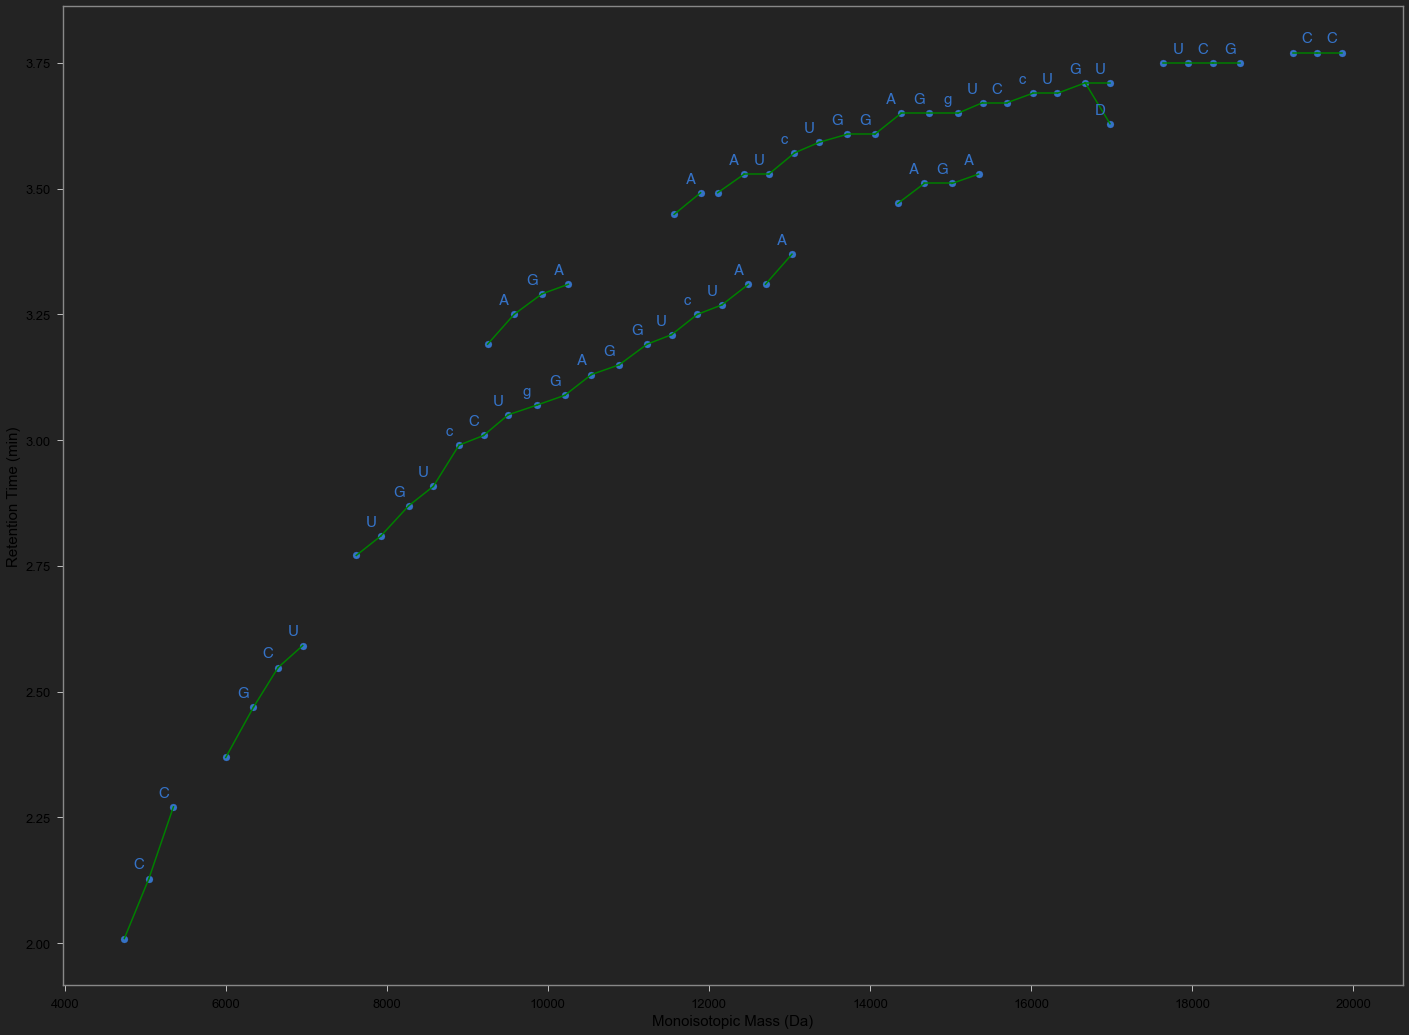

In [43]:
bcr_5p = base_calling_random(df_3p_cca)
plt, _ = plot_basecalling2(*bcr_5p, annotate=False)

In [48]:
df_3p_cc.loc[:,'type'] = 'Reg'
df_3p_cca.loc[:,'type'] = 'Methyl'
df_merge = pd.concat([df_3p_cc, df_3p_cca])
fig = px.scatter(df_merge, x='Mass', y='RT', color='type')
fig.update_layout(
    width=960*1.2,
    height=720*1.2,
    margin=dict(l=0, r=0, t=20, b=0),
    paper_bgcolor="LightSteelBlue",
)

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

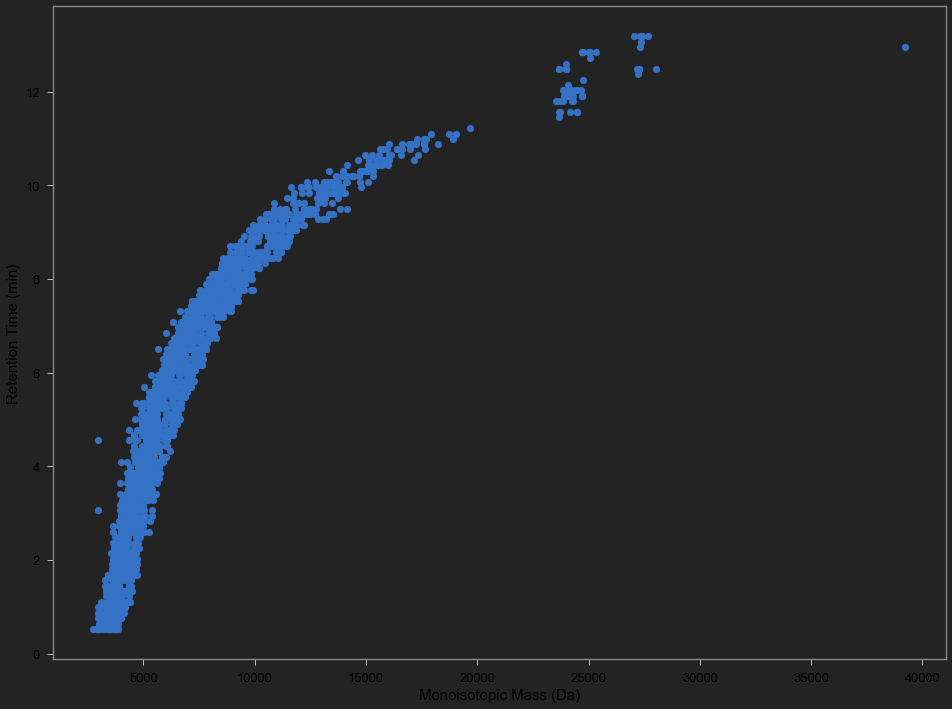

In [123]:
df_total = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/total_tRNA_acid_deg_oligosdegcoplex4.xlsx')
df_total.shape
df_total = thermo_df(df_total)
plot_zone(df_total)

In [126]:
df_total_25k = df_total[(df_total.Mass > 22000) & (df_total.Mass < 26000)]

In [127]:
px.scatter(x=df_total_25k.Mass, y=df_total_25k.Vol)

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

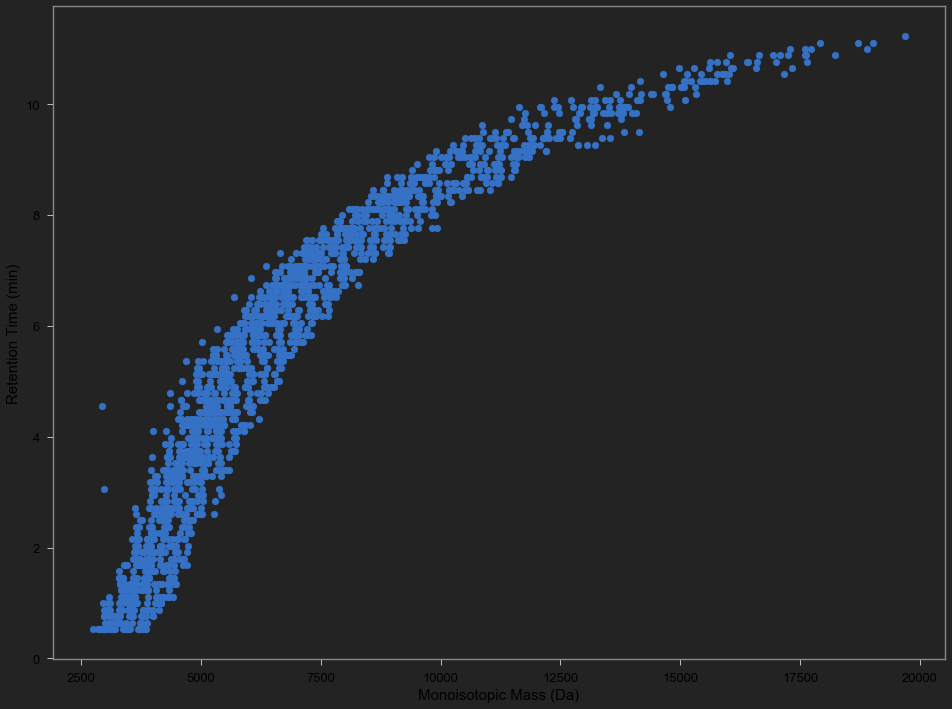

In [131]:
df_sample = df_total[df_total.Mass < 22000]
df_sample.shape
plot_zone(df_sample)

In [132]:
full_mass = 23904.22164 #24252.315242 #24581.374101 
df_3p_cc, df_5p_cc = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

df3 58 df5 58


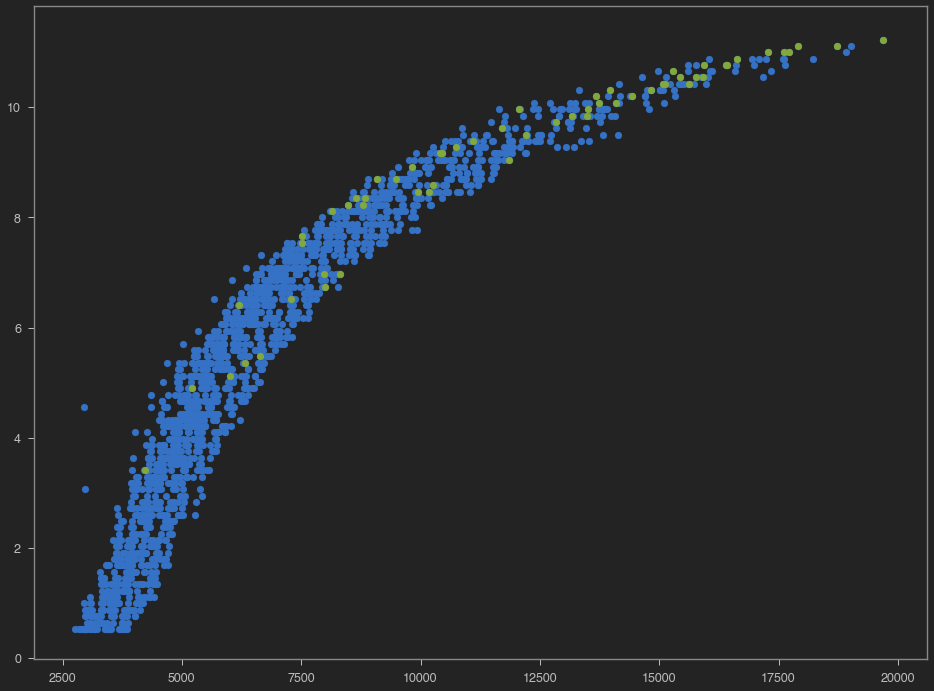

In [133]:
plt.figure(figsize=(16, 12))
plt.scatter(df_sample.Mass, df_sample.RT)
plt.scatter(df_3p_cc.Mass, df_3p_cc.RT)

In [134]:

px.scatter(x=df_3p_cc.Mass, y=df_3p_cc.RT)

In [ ]:
full_mass = 24581.374101 
df_3p_cca, df_5p_cca = computational_data_seperation(df_sample, df_sample, full_mass, ignore_endpoints=True)

# Utils

In [36]:
def plot_basecalling2(df, mass_pairs, endpoints=pd.DataFrame(), annotate=True, plt=None):
#     if in_plt:
#         plt = in_plt
#     else:
    if not plt:
        plt = matplotlib.pyplot
    fig = plt.figure(figsize=(24, 18))
#     plt.xlabel('Mass (Da)')
#     plt.ylabel('Retention Time (min)')
    plt.xlabel('Monoisotopic Mass (Da)', fontname="Arial", fontsize=15, color='black')
    plt.ylabel('Retention Time (min)', fontname="Arial", fontsize=15, color='black')
#     plt.xticks(range(0, 25001, 2500), fontname="Arial", size=13, color='black')
#     plt.yticks(range(0, 25, 2), fontname="Arial", size=13, color='black')
    plt.xticks(fontname="Arial", size=13, color='black')
    plt.yticks(fontname="Arial", size=13, color='black')
        
    plt.scatter(df.Mass, df.RT)

    for t in mass_pairs:
        df_pair = df[df.Mass.isin(t)]
        if df_pair.empty:
            continue
        plt.plot(df_pair.Mass, df_pair.RT, 'green')
        
        idmax = df_pair['Mass'].idxmax()
        plt.annotate(s=t[2], size=15, xy=(df_pair.loc[idmax].Mass, df_pair.loc[idmax].RT), 
                     textcoords="offset points", xytext=(-10, 10), ha='center', color='C0')
        
        if not annotate:
            continue
            
        mass = '{:.2f}'.format(df_pair.loc[idmax].Mass)
        plt.annotate(s=mass, size=13, xy=(df_pair.loc[idmax].Mass, df_pair.loc[idmax].RT), 
                     textcoords="offset points", xytext=(10, -20), ha='center')

    if not endpoints.empty:
        plt.scatter(endpoints.Mass, endpoints.RT, color='r')
        print(endpoints[['Mass', 'RT', 'Vol']])
#     plt.show()
    return plt, fig